## Описание проекта
Мы работаем в интернет-магазине, который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й.


Описание данных:
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.
---

## Шаг 1. Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd # импортируем необходимые библиотеки
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/games.csv')
data.info()
display(data.sample(10)) # посмотрим сэмпл в 10 строк

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
632,Final Fantasy V,SNES,1992.0,Role-Playing,0.00,0.00,2.43,0.02,NaN,NaN,NaN
1102,NBA Ballers,PS2,2004.0,Sports,0.81,0.63,0.00,0.21,83.0,9.2,E
1305,Donkey Kong,2600,1981.0,Platform,1.36,0.08,0.00,0.02,NaN,NaN,NaN
14326,Call of Juarez: Bound in Blood,PC,2009.0,Shooter,0.00,0.03,0.00,0.00,78.0,8,M
4093,Wu-Tang: Shaolin Style,PS,1998.0,Fighting,0.27,0.18,0.00,0.03,NaN,NaN,NaN
9172,The Bombing Islands,PS,1997.0,Platform,0.08,0.05,0.00,0.01,NaN,NaN,NaN
3504,Cabela's Dangerous Hunts 2011,Wii,2010.0,Sports,0.52,0.02,0.00,0.04,NaN,tbd,T
7949,Ty the Tasmanian Tiger 3: Night of the Quinkan,PS2,2005.0,Action,0.09,0.07,0.00,0.02,68.0,8.1,E10+
2684,ISS Pro Evolution,PS,1998.0,Sports,0.00,0.00,0.71,0.05,94.0,8.7,E
8102,Batman: Vengeance,GBA,2001.0,Adventure,0.13,0.05,0.00,0.00,68.0,tbd,E


## Шаг 1. Вывод
С помощью info() и sample() заметили ряд проблем в данных. Регистр, пропуски и тип данных требуют подготовки к анализу.

## Шаг 2. Подготовим данные

In [3]:
lower = data.columns.str.lower() # переведем названия колонок в нижний регистр
data.set_axis(lower, axis='columns', inplace=True)

In [4]:
print('Количество дубликатов:', data.duplicated().sum()) # дублей не зафиксировано
data.dropna(subset = ['year_of_release'], inplace=True) # пропущенных значений около 1-2%

data['year_of_release'] = data['year_of_release'].astype(int) # сменим тип данных, можно сделать и череp dt
data['rating'] = data['rating'].fillna('not_def') # заполним пропуски в рейтинге
#data['year_of_release'] = (pd.to_datetime(data['year_of_release'], format='%Y')).dt.year

Количество дубликатов: 0


In [5]:
data['user_score'] = data['user_score'].replace('tbd', 7.1).astype(float) # сделаем замену значений 'tbd' средним значением 7.1
# это общее среднее, т.е. data.query('user_score != "tbd"')['user_score'].mean() 
genres = data['genre'].unique() # получим список жанров для цикла

for type in genres:
    data.loc[(data['genre'] == type) & (data['critic_score'].isnull()), 'critic_score'] = \
data.loc[data['genre'] == type, 'critic_score'].mean()
    data.loc[(data['genre'] == type) & (data['user_score'].isnull()), 'user_score'] = \
data.loc[data['genre'] == type, 'user_score'].mean()

data['critic_score'] = data['critic_score'].round(1) # округлим до 1 знака после запятой   

In [6]:
print('Объем продаж в Северной Америке:', data['na_sales'].sum().round(1), 'млн. копий')
print('Объем продаж в Европе:', data['eu_sales'].sum().round(1), 'млн. копий')
print('Объем продаж в Японии:', data['jp_sales'].sum().round(1), 'млн. копий')
print('Объем продаж в других странах:', data['other_sales'].sum().round(1), 'млн. копий')
# Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец
data['sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

Объем продаж в Северной Америке: 4343.2 млн. копий
Объем продаж в Европе: 2400.2 млн. копий
Объем продаж в Японии: 1290.7 млн. копий
Объем продаж в других странах: 782.7 млн. копий


In [7]:
data.info()
display(data) # проверим

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 12 columns):
name               16444 non-null object
platform           16446 non-null object
year_of_release    16446 non-null int64
genre              16444 non-null object
na_sales           16446 non-null float64
eu_sales           16446 non-null float64
jp_sales           16446 non-null float64
other_sales        16446 non-null float64
critic_score       16444 non-null float64
user_score         16444 non-null float64
rating             16446 non-null object
sales              16446 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.000000,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,68.1,7.256172,not_def,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.300000,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.000000,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,72.7,7.603911,not_def,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,66.7,7.065250,not_def,0.01
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,72.0,6.991997,not_def,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,65.3,7.125991,not_def,0.01
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,68.1,7.256172,not_def,0.01


## Шаг 2. Вывод
Привели в нижний регистр названия столбцов. Убедились в отсутствии дубликатов. \
Избавились от пропусков в колонке *year_of_release* с помощью dropna. Грамотно их заполнить можно только вручную, что не целесообразно, ведь таких данных у нас около 1-2% (Вытаскивать год из *name*, плохая идея, так как часто в названиях работает формула год_выпуска + 1). \
Удалять данные с пропусками из колонок *critic_score*, *user_score*, *rating* нельзя, потеряем много данных. \
В *rating* заполним значением **not_def** (не определено), так как это категориальная переменная - ее не получится использовать в корреляционном анализе. А *critic_score* и *user_score* заполним средним, но средним с привязкой к конкретному жанру. Отметим значение tbd в *user_score* (2208 значений), это аббревиатура To Be Determined, то есть "Будет определено". Можно было бы предположить, что это "свежие" игры, которые успели оценить критики, а пользователи нет. Но данная аббревиатура встречается и в "старых" играх.


## Шаг 3. Проведем исследовательский анализ данных

In [8]:
print(data['year_of_release'].value_counts()) # сколько игр выпускалось в разные годы
data = data.query('year_of_release >= 2000')

2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
1996     263
1995     219
1994     121
1993      62
1981      46
1992      43
1991      41
1982      36
1986      21
1983      17
1989      17
1987      16
1990      16
1988      15
1984      14
1985      14
1980       9
Name: year_of_release, dtype: int64


Посмотрели сколько игр выпускалось в разные годы. Условно можно сказать, что данные 80х и 90х годов нерелевантны, количество игр там небольшое, а самое главное это эволюция платформ и жанров. Сделаем срез от 2000 года.

In [9]:
data2=(data
           .pivot_table(index='platform', values='sales', aggfunc='sum')
           .sort_values(by='sales', ascending = False)
           .head(11))
display(data2) # Взглянем на топ платформ по продажам
data3 = data.query('platform in @data2.index') # срез по топ-11 платформ

,sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.76
PS4,314.14
GBA,312.88
PSP,289.53
3DS,257.81


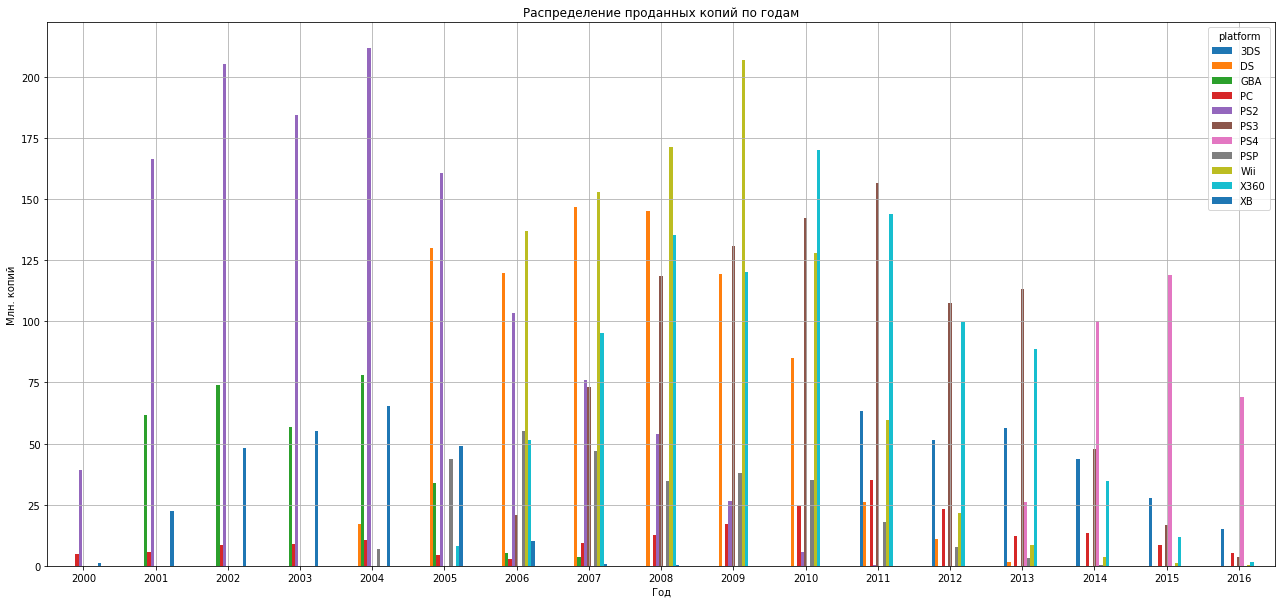

In [10]:
(data3
.pivot_table(index='year_of_release', columns='platform', values='sales', aggfunc='sum')
.plot(kind='bar', figsize=(22,10), rot=0, grid=True) )
plt.title('Распределение проданных копий по годам')
plt.xlabel('Год')
plt.ylabel('Млн. копий')
plt.show() # построим распределение

Посмотрим как менялись продажи по платформам. Выбрали платформы с наибольшими суммарными продажами (можно было бы взять топ-10, но мы сделали *head(11)*, очень хотелось, чтобы PC была тоже учтена). Построили распределение по годам. На полученном графике, можно наблюдать как заходят и покидают рынок новые платформы. Например, примерный срок жизни платформы PS2 - 9 лет, а DS - 7 лет.

Мы делаем прогноз на 2017 год, поэтому, чтобы ответить на вопрос какие платформы лидируют по продажам, растут или падают, нужно сделать срез данных с 2010 года, по всем платформам, таким образом оценим перспективные направления. Cпад в 2016 году объясняется неполнотой данных за этот год.

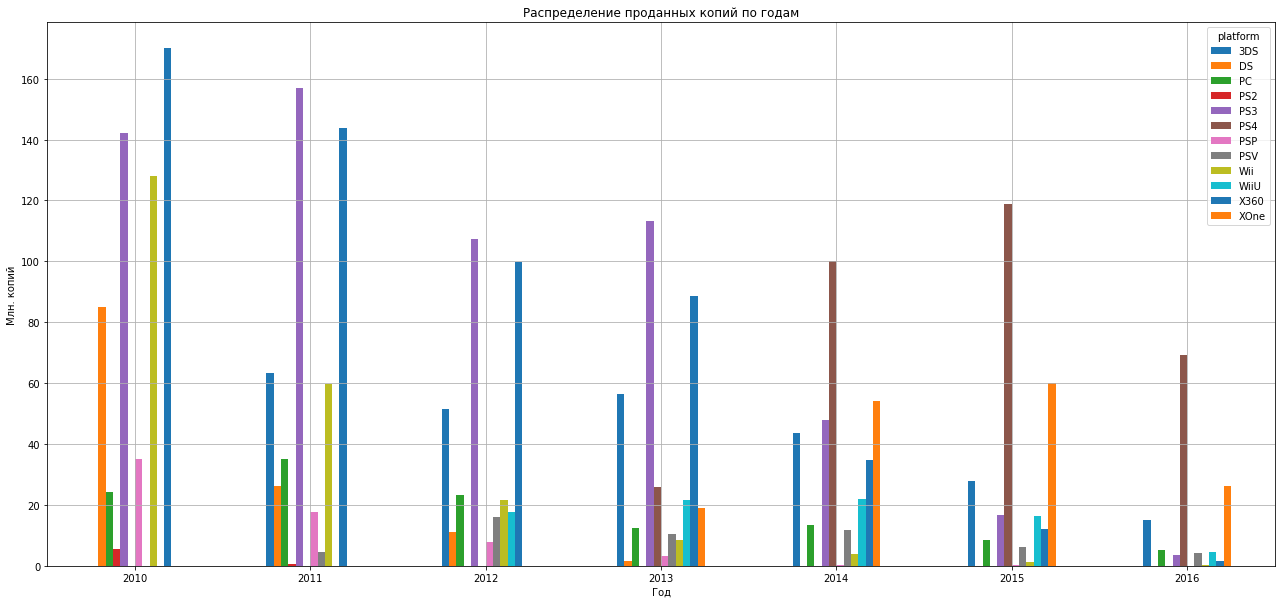

In [11]:
data_2010 = data.query('year_of_release >= 2010') # новый срез по году
(data_2010
.pivot_table(index='year_of_release', columns='platform', values='sales', aggfunc='sum')
.plot(kind='bar', figsize=(22,10), rot=0, grid=True) )
plt.title('Распределение проданных копий по годам')
plt.xlabel('Год')
plt.ylabel('Млн. копий')
plt.show()

Исходя из такого распределения, перспективными на 2017 год будут PS4, XOne и, наверное, PC как платформа не имеющая срока жизни как такового.

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. \
Такой вид диаграммы в удобной форме показывает медиану, среднее, нижний и верхний квартили, минимальное и максимальное значение выборки и выбросы. Несколько таких ящиков можно нарисовать бок о бок, чтобы визуально сравнивать одно распределение с другим. Расстояния между различными частями бокса позволяют определить степень разброса и асимметрии данных и выявить выбросы.

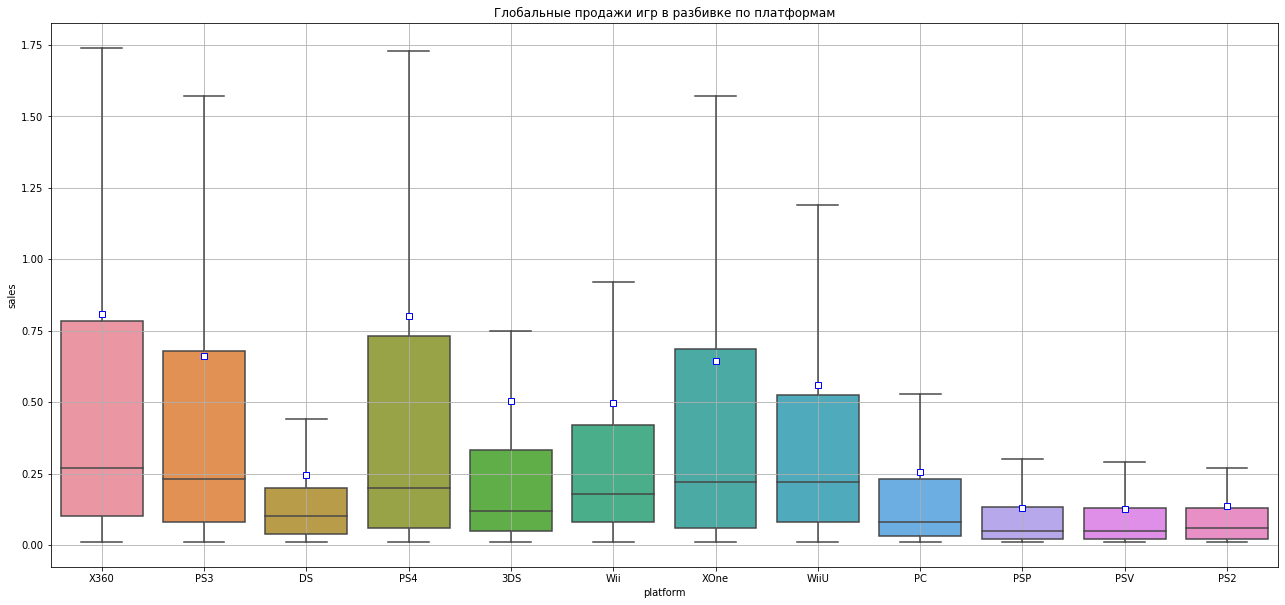

count    392.000000
mean       0.801378
std        1.609456
min        0.010000
25%        0.060000
50%        0.200000
75%        0.730000
max       14.630000
Name: sales, dtype: float64

In [12]:
plt.figure(figsize=(22,10))
sns.boxplot(x='platform', y= 'sales', data=data_2010, showfliers=False, 
            showmeans=True, meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"})
plt.title('Глобальные продажи игр в разбивке по платформам')
plt.grid(True)
plt.show()
 # сверим корректность графика путем вызова describe() по какой-нибудь платформе
data.query('platform == "PS4" ')['sales'].describe()

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

In [13]:
df_PS3 = data.query('platform == "PS3"') # выберем для исследования платформу PS3

Зависимость объема продаж от отзывов критиков: 0.4231676245103803


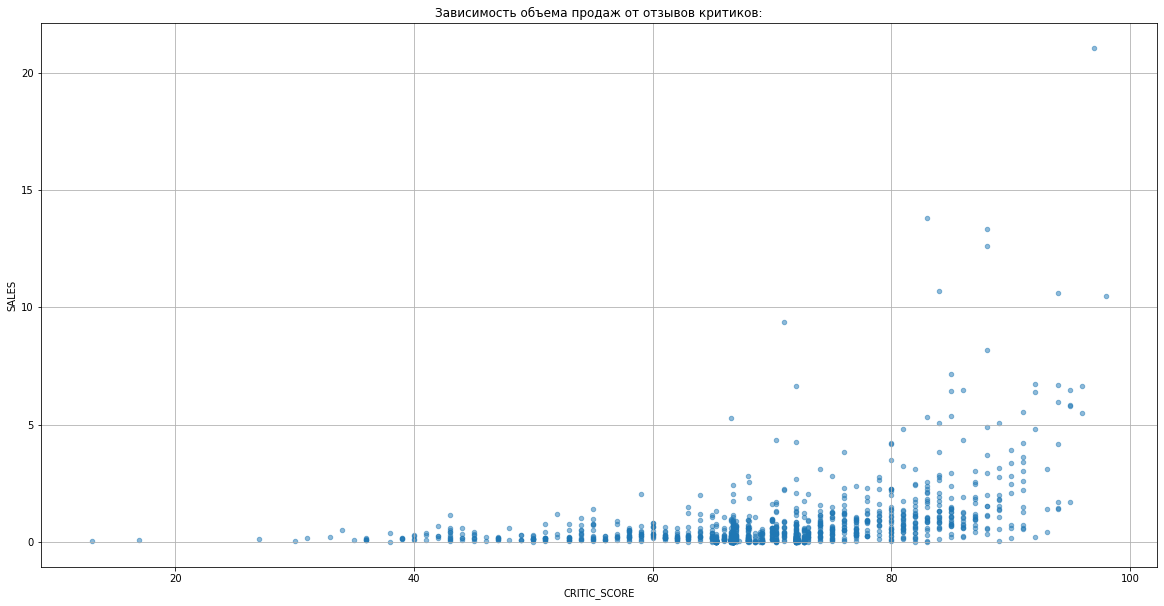

In [14]:
print('Зависимость объема продаж от отзывов критиков:', df_PS3['critic_score'].corr(df_PS3['sales']))
df_PS3.plot(x = 'critic_score', y = 'sales', kind='scatter', alpha = 0.5, grid = True, figsize=(20, 10))
            
plt.title('Зависимость объема продаж от отзывов критиков:')
plt.xlabel('CRITIC_SCORE')
plt.ylabel('SALES')
plt.show()

Зависимость объема продаж от отзывов пользователей: 0.0804074781346272


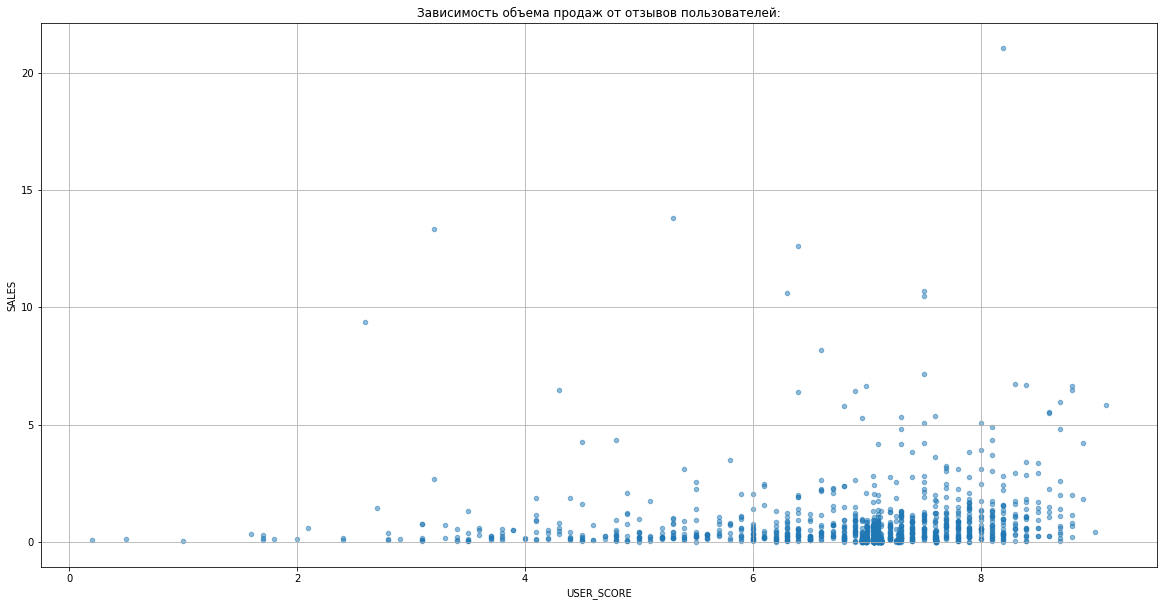

In [15]:
print('Зависимость объема продаж от отзывов пользователей:', df_PS3['user_score'].corr(df_PS3['sales']))
df_PS3.plot(x = 'user_score', y = 'sales', kind='scatter', alpha = 0.5, grid = True, figsize=(20, 10))
            
plt.title('Зависимость объема продаж от отзывов пользователей:')
plt.xlabel('USER_SCORE')
plt.ylabel('SALES')
plt.show()

Корреляция от отзывов критиков сильнее, чем от отзывов пользователей. Это видно и по диаграмме рассеивания и по коэффициенту Пирсона, но не стоит забывать, что его нулевое значение может быть не оттого, что связи нет, а потому что у неё более сложный, не линейный характер. \
Путем замены значения **"PS3"** в строчке *df_PS3 = data.query('platform == "PS3"')* можно визуализировать картину корреляции с другими платформами.

Посмотрим на общее распределение игр по жанрам.  Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

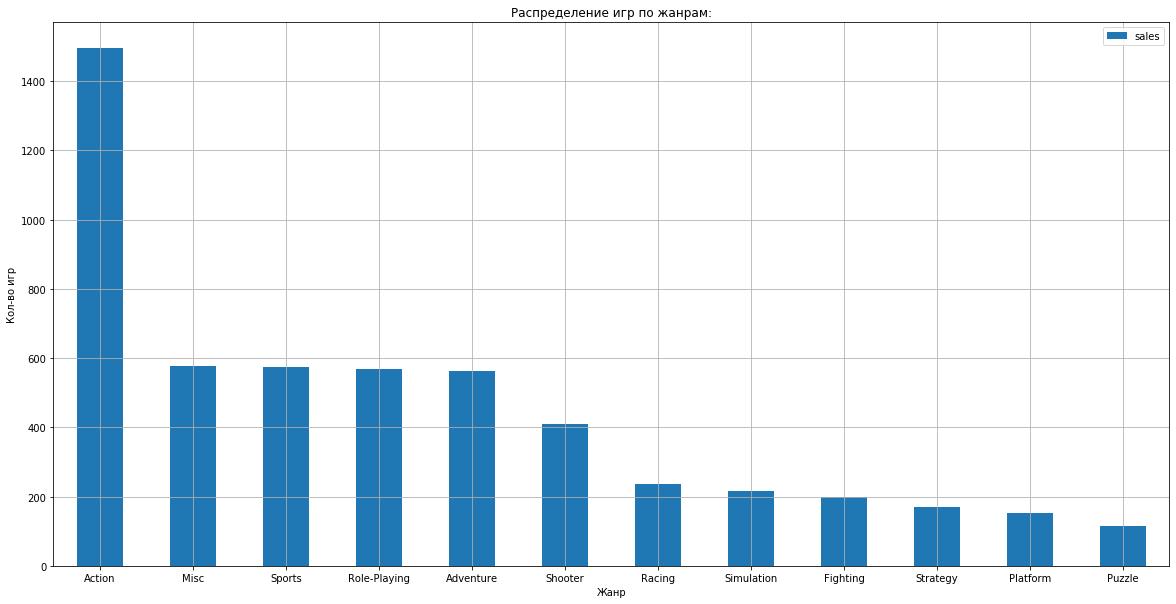

In [16]:
(data_2010.pivot_table(index='genre', values='sales', aggfunc='count')
                 .sort_values(by='sales', ascending = False)
                 .plot(kind='bar', figsize=(20,10), rot=0, grid=True) )
plt.title('Распределение игр по жанрам:')
plt.xlabel('Жанр')
plt.ylabel('Кол-во игр')
plt.show()

In [17]:
(data_2010.pivot_table(index='genre', values='sales', aggfunc='sum')).sort_values(by='sales', ascending = False)
# топ продаж

,sales
genre,
Action,673.09
Shooter,479.74
Sports,328.39
Role-Playing,315.28
Misc,234.56
Racing,122.68
Platform,119.72
Fighting,81.59
Simulation,71.75


Самыми продаваемыми жанрами являются Action, Shooter, Sports и Role-Playing, а Puzzle, Strategy и Adventure замыкают этот список. Интересно отметить жанр Shooter. Игр с таким жанром выпускается почти в три раза меньше, чем Action, а вот продается в полтора раза меньше копий.

## Шаг 3. Вывод
Провели исследовательский анализ имеющихся данных. Приняли решение, за какой период возьмем данные, чтобы они были актуальными и позволили решить поставленные задачи. Оценили как влияет рейтинг критиков и пользователей на глобальные продажи игр. Показали какие жанры являются самыми популярными и продаваемыми. 

## Шаг 4. Составим портрет пользователя каждого региона

Определим для пользователя каждого региона (NA, EU, JP) топ-5 популярных платформ и жанров.

In [18]:
print('Портрет пользователя из Северной Америки. Топ-5 популярных платформ и жанров.')
display(data_2010.pivot_table(index = 'platform', values = 'na_sales', aggfunc='sum')
         .sort_values(by='na_sales', ascending = False).head() )
display(data_2010.pivot_table(index = 'genre', values = 'na_sales', aggfunc='sum')
        .sort_values(by='na_sales', ascending = False).head() )

Портрет пользователя из Северной Америки. Топ-5 популярных платформ и жанров.


,na_sales
platform,
X360,334.18
PS3,229.25
Wii,121.20
PS4,108.74
XOne,93.12


,na_sales
genre,
Action,290.64
Shooter,237.47
Sports,156.81
Misc,123.80
Role-Playing,112.05


In [19]:
print('Портрет пользователя из Европы. Топ-5 популярных платформ и жанров.')
display(data_2010.pivot_table(index = 'platform', values = 'eu_sales', aggfunc='sum')
         .sort_values(by='eu_sales', ascending = False).head() )
display(data_2010.pivot_table(index = 'genre', values = 'eu_sales', aggfunc='sum')
        .sort_values(by='eu_sales', ascending = False).head() )

Портрет пользователя из Европы. Топ-5 популярных платформ и жанров.


,eu_sales
platform,
PS3,213.60
X360,163.41
PS4,141.09
PC,68.82
Wii,65.91


,eu_sales
genre,
Action,233.63
Shooter,171.45
Sports,116.84
Role-Playing,75.48
Misc,66.09


In [20]:
print('Портрет пользователя из Японии. Топ-5 популярных платформ и жанров.')
display(data_2010.pivot_table(index = 'platform', values = 'jp_sales', aggfunc='sum')
         .sort_values(by='jp_sales', ascending = False).head() ) 
display(data_2010.pivot_table(index = 'genre', values = 'jp_sales', aggfunc='sum')
        .sort_values(by='jp_sales', ascending = False).head() )

Портрет пользователя из Японии. Топ-5 популярных платформ и жанров.


,jp_sales
platform,
3DS,100.62
PS3,59.26
PSP,42.20
DS,27.90
PSV,21.84


,jp_sales
genre,
Role-Playing,103.54
Action,72.20
Misc,24.29
Platform,15.81
Adventure,15.67


In [21]:
def pivot_maker(sale):
    print('Портрет пользователей', sale, 'Топ-5 популярных платформ и жанров.')
    df1 = (data_2010.pivot_table(index='platform', values=sale, aggfunc='sum')
                    .sort_values(by=sale, ascending=False).head())
    df2 = (data_2010.pivot_table(index = 'genre', values = sale, aggfunc='sum')
        .sort_values(by=sale, ascending = False).head())
    df3 = (data_2010.pivot_table(index='rating', values=sale, aggfunc='sum')
        .sort_values(by=sale, ascending = False))
    return display(df1, df2, df3)

display(pivot_maker('eu_sales'))
display(pivot_maker('na_sales'))
display(pivot_maker('jp_sales'))

Портрет пользователей eu_sales Топ-5 популярных платформ и жанров.


,eu_sales
platform,
PS3,213.60
X360,163.41
PS4,141.09
PC,68.82
Wii,65.91


,eu_sales
genre,
Action,233.63
Shooter,171.45
Sports,116.84
Role-Playing,75.48
Misc,66.09


,eu_sales
rating,
M,292.04
E,197.34
not_def,139.44
T,113.08
E10+,99.28
RP,0.03
EC,0.00


None

Портрет пользователей na_sales Топ-5 популярных платформ и жанров.


,na_sales
platform,
X360,334.18
PS3,229.25
Wii,121.20
PS4,108.74
XOne,93.12


,na_sales
genre,
Action,290.64
Shooter,237.47
Sports,156.81
Misc,123.80
Role-Playing,112.05


,na_sales
rating,
M,382.22
E,271.15
T,160.81
E10+,159.38
not_def,155.72
EC,1.13
RP,0.00


None

Портрет пользователей jp_sales Топ-5 популярных платформ и жанров.


,jp_sales
platform,
3DS,100.62
PS3,59.26
PSP,42.20
DS,27.90
PSV,21.84


,jp_sales
genre,
Role-Playing,103.54
Action,72.20
Misc,24.29
Platform,15.81
Adventure,15.67


,jp_sales
rating,
not_def,171.49
E,47.87
T,42.11
M,30.45
E10+,13.22
EC,0.00
RP,0.00


None

Влияет ли рейтинг ESRB на продажи в отдельном регионе? Прежде всего дадим расшифровку\
«EC» («Early childhood») — «Для детей младшего возраста» \
«E» («Everyone») — «Для всех» \
«E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше» \
«T» («Teen») — «Подросткам» \
«M» («Mature») — «Для взрослых» \
«RP» («Rating Pending») — «Рейтинг ожидается» \
«not_def» — «Не определен»

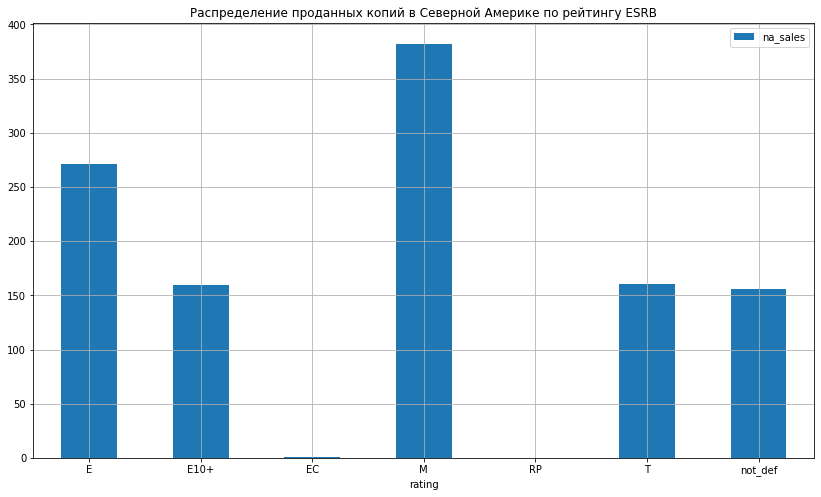

In [22]:
(data_2010.pivot_table(index='rating', values='na_sales', aggfunc='sum')
         .plot(kind='bar', figsize=(14,8), rot=0, grid=True))

plt.title('Распределение проданных копий в Северной Америке по рейтингу ESRB')
plt.show()

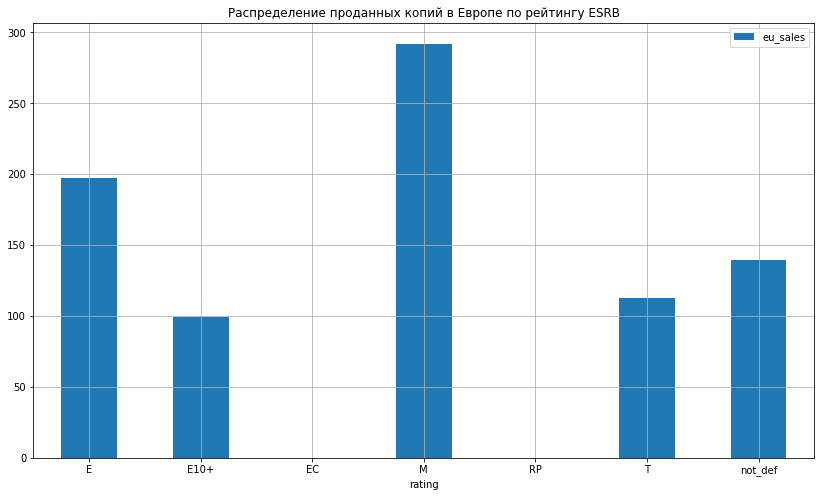

In [23]:
(data_2010.pivot_table(index='rating', values='eu_sales', aggfunc='sum')
         .plot(kind='bar', figsize=(14,8), rot=0, grid=True))

plt.title('Распределение проданных копий в Европе по рейтингу ESRB')
plt.show()

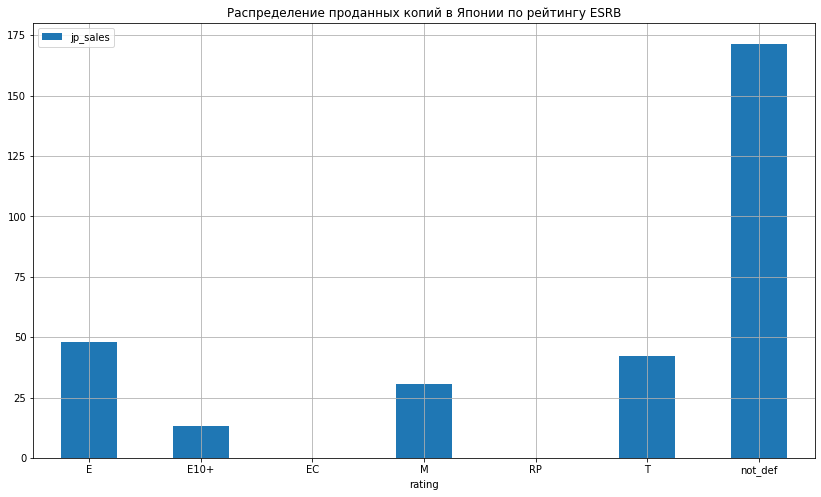

In [24]:
(data_2010.pivot_table(index='rating', values='jp_sales', aggfunc='sum')
         .plot(kind='bar', figsize=(14,8), rot=0, grid=True))

plt.title('Распределение проданных копий в Японии по рейтингу ESRB')
plt.show()

## Шаг 4. Вывод
Составили портрет пользователя каждого региона, путем определения самых популярных платформ и жанров. Таким образом портреты пользователя из Северной Америки и Европы очень похожи между собой. А вот пользователь Японии сильно выделяется, отдавая предпочтение портативному геймингу. \
Оценили влияние рейтинга ESRB на продажи в каждом регионе, опять сходство между Америкой и Европой. Отдельно стоит отметить высокий процент значения **not_def** в Японском сегменте, которым мы заменили пропуски.

Дополним: \
Таким образом имеем следующий портрет пользователя: \
   "Американец" играет на платформах Х360 и PS3, преимущественно в action, shooter и sports c рейтингом "для взрослых" или "для всех";\
    "Европеец" играет на платформах Х360, PS3 и PS4, преимущественно в action, shooter и sports c рейтингом "для взрослых" или "для всех";\
    "Японец" играет на платформах 3DS, PS3 и PSP, преимущественно в rpg и action c рейтингом "для взрослых", "для всех" или "для подростков";

## Шаг 5. Проверим гипотезы

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые; \
Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Алгоритм проверки стат. гипотез всегда начинаем с формулирования гипотез. Сначала формулируем нулевую гипотезу Н(o) - средние пользовательские рейтинги платформ «Xbox One» и «PC» одинаковые (равенство средних). Исходя из нее формулируем альтернативную гипотезу Н(1) - средние пользовательские рейтинги платформ «Xbox One» и «PC» разнятся (не равенство средних). Решение о принятии или отвержении нулевой гипотезы примем по значению p-value (это вероятность получить наблюдаемый результат при условии что нулевая гипотеза верна). Общепринятые пороговые значения 5% и 1%.

Проверим гипотезу о равенстве средних с помощью метода scipy.stats.ttest_ind(), ведь без проведения корректного теста нельзя считать отличия случайными или разницу достаточной, чтобы полагать суммы выручки разными.

In [25]:
alpha = .05 # установим пороговое значение
results = st.ttest_ind(data_2010.query('platform == "XOne"')['user_score'],\
                       data_2010.query('platform == "PC"')['user_score'], equal_var = True)
print(results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.82235343534532
Не получилось отвергнуть нулевую гипотезу


Полученное нами значение p-value говорит о том, что хоть средние пользовательские рейтинги платформ Xbox One и PC неодинаковы, с вероятностью в почти 82% такое (или большее) различие можно получить случайно. Это слишком большая вероятность, чтобы делать вывод о значимом различии между средними.

Cредние пользовательские рейтинги жанров Action и Sports не равны. Сформулируем нулевую и альтернативную. \
Нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports равны. \
Альтернативная гипотеза: средние пользовательские рейтинги жанров Action и Sports не равны.

In [26]:
alpha = .05 # установим пороговое значение
results = st.ttest_ind(data_2010.query('genre == "Action"')['user_score'],\
                       data_2010.query('genre == "Sports"')['user_score'], equal_var = True)
print(results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

4.8394634083407715e-20
Отвергаем нулевую гипотезу


Полученное значение p-value говорит о том, что такие средние рейтинги, с вероятностью в почти 0% можно получить случайно. Делаем вывод о значимом различии между средними рейтингами жанра Action и Sports.

## Шаг 5. Вывод
Сформулировали нулевые и альтернативные гипотезы, выбрали пороговое значение в 5% и с помощью метода scipy.stats.ttest_ind() проверили выдвинутые гипотезы.
 - средние пользовательские рейтинги платформ Xbox One и PC одинаковые - не получилось отвергнуть нулевую гипотезу
 - средние пользовательские рейтинги жанров Action и Sports разные - отвергли нулевую гипотезу
 
Обратим внимание на формулировку результатов и отметим, что данные никогда не смогут доказать или подтвердить гипотезу. Это принципиально важно: обладая лишь выборкой, мы никогда не знаем ничего о генеральной совокупности достоверно. А если бы и знали, статистический тест был бы уже не нужен. Мы можем лишь сделать предположение о генеральной совокупности, и при условии того, что оно верно, посчитать, насколько вероятно увидеть в выборке то, что мы в ней видим. Если эта вероятность относительно высока — данные не дают основания отвергнуть это предположение. Если эта вероятность низка — по наблюдаемым данным можно сделать вывод, что, скорее всего, наше предположение всё-таки неверно (но не опровергнуть его и не доказать обратное).

## Шаг 6. Общий вывод

Провели исследовательский анализ предоставленных данных. Получили среднее время "жизни" платформы и определили актуальный период исследования. Выявили лидеров продаж по жанрам и платформам и как оценки критиков и пользователей влияют на эти продажи. Составили региональный портрет пользователя с его предпочтениями по платформам и жанрам, указали, игры с какими рейтингами преобладают в этих регионах. Проверили выдвинутые гипотезы. \
По итогу, планируя кампанию на 2017 год, интернет-магазину «Стримчик» следует делать упор на такие набирающие популярность платформы как PS4, XOne и вечная PC. По жанрам надо опираться на пользователя из Северной Америки и Европы, это жанры Action, Shooter и Sports. Внимательно отслеживать игры с высокими рейтингами критиков, исследование показало, что есть прямая зависимость с высоким объемом продаж.

Дополним:

Для сегментации рекламной кампании по регионам можно использовать полученные портеты пользователей, чтобы правильно выбрать жанр и рейтинг ESRB: \
"Американец" играет преимущественно в action, shooter и sports c рейтингом "для взрослых" или "для всех";\
"Европеец" играет преимущественно в action, shooter и sports c рейтингом "для взрослых" или "для всех";\
"Японец" играет преимущественно в rpg и action c рейтингом "для взрослых", "для всех" или "для подростков";